In [60]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np  

def show_image(image):
    plt.figure()
    plt.imshow(np.abs(image), cmap='gray')
    plt.show()


def show_kspace(kspace):
    plt.figure()
    plt.imshow(np.log(np.abs(kspace)), cmap='gray')
    plt.show()


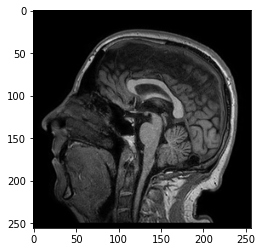

In [61]:
sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)
img = t1[1][0][45]

show_image(img)


(85, 256, 2)


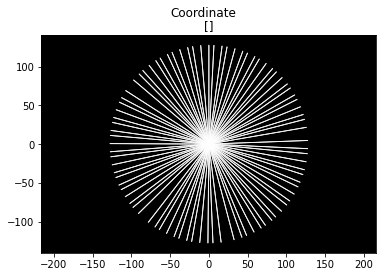

In [99]:
## Generate coordinate
import sigpy as sp
import sigpy.plot as pl
from sigpy.mri import radial
import sigpy.mri as mr


af = 3
coord = sp.mri.radial([int(256/af),256,2],[256,256])
print(coord.shape)
pl.ScatterPlot(coord, title='Coordinate')

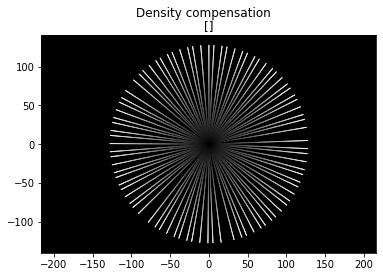

(85, 256)

In [100]:
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
pl.ScatterPlot(coord, dcf, title='Density compensation')
dcf.shape

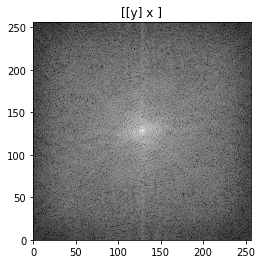

In [91]:
## FT on original img to get k-space
ksp = sp.fft(img)
pl.ImagePlot(ksp,mode = 'l')

In [93]:
coord.shape

(256, 256, 2)

In [82]:
# Cartesian sample and reconstruct
def cartesian_sample(af,ksp):
    cartesina_sample = range(0,256,af)
    ksp_s = np.zeros(ksp.shape,dtype = "complex_")
    for i in cartesina_sample:
        ksp_s[:,i] = ksp[:,i]

    # Inverse FT to reconstruct img with cartesian sample
    img_if = sp.ifft(ksp_s)
    show_image(img_if)

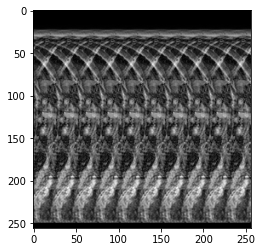

In [83]:
cartesian_sample(10,ksp)

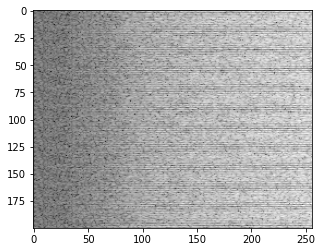

In [26]:
# Sample on radial coordinate
k_sample = sp.interpolate(ksp ,coord, width=2, param=1)
show_kspace(k_sample)


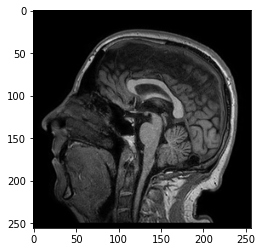

In [29]:
# Inverse FT to reconstruct img
img_if = sp.ifft(ksp)
show_image(img_if)
# pl.ImagePlot(img_if,mode='r')

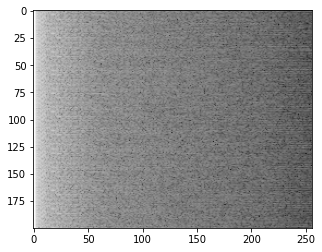

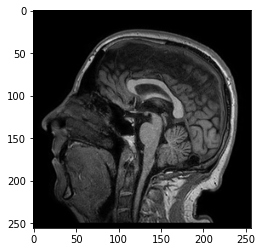

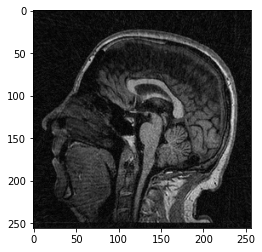

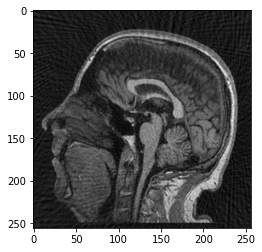

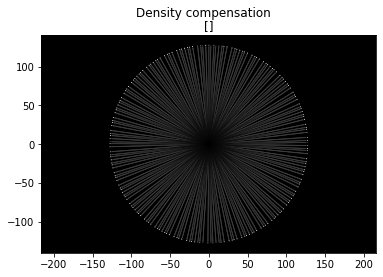

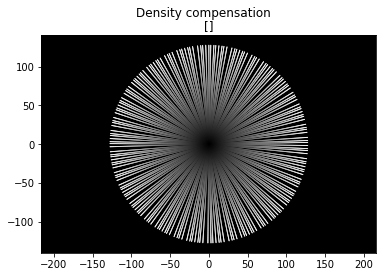

In [37]:
# NUFT to reconstruct img with density compensation
# img_nu = sp.nufft_adjoint(k_sample*dcf, coord, oshape=(256,256),oversamp=5, width=4)
from matplotlib.pyplot import figure
from sigpy.mri import dcf, samp

img_ = img.astype('float64')
ksp_nu = sp.nufft(img_, coord)
pm_dcf = dcf.pipe_menon_dcf(coord, show_pbar=False)
dcf_2 = (coord[..., 0]**2 + coord[..., 1]**2)**0.5

img_dcf = sp.nufft_adjoint(ksp_nu * dcf_2, coord, oshape=img.shape)
img_pm_dcf = sp.nufft_adjoint(ksp_nu * pm_dcf, coord, oshape=img.shape)

show_kspace(ksp_nu)
show_image(img)
figure
show_image(img_dcf)
figure
show_image(img_pm_dcf)
figure
pl.ScatterPlot(coord, pm_dcf, title='Density compensation')
figure
pl.ScatterPlot(coord, dcf_2, title='Density compensation')



In [50]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def evaluate(img,img_recon):
    psnr = peak_signal_noise_ratio(img,abs(img_recon))
    ssim_value = ssim(img, img_recon, data_range=img_recon.max()-img_recon.min())
    mse = mean_squared_error(img, abs(img_recon))
    print("PSNR = {}".format(psnr))
    print("SSIM = {}".format(ssim_value))
    print("MSE = {}".format(mse))
    print(" ")

In [51]:
## Task 2 Quality Assessment
img = t1[1][0][45]
evaluate(img,img)
evaluate(img,img_if)
evaluate(img,img_dcf)
evaluate(img,img_pm_dcf)


PSNR = inf
SSIM = 1.0
MSE = 0.0
 


/opt/anaconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/var/folders/m4/9tqx2h0977b4g9l7n72kv3280000gn/T/ipykernel_19158/630184591.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(img,(img_recon))


ValueError: complex valued input is not supported

In [69]:
## Cartesian Sample
cartesina_sample = range(0,256,2)
ksp_s = np.zeros(ksp.shape,dtype = "complex_")
for i in cartesina_sample:
    ksp_s[:,i] = ksp[:,i]

In [76]:
# Set parameters
max_iter = 30
lamda = 0.01

# Estimate sensitivity map make coil = 1
ksp_s = np.expand_dims(ksp_s, axis=0)
mps = mr.app.EspiritCalib(ksp).run()
# pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')


# Reconsruct with SENSE
img_sense = mr.app.SenseRecon(ksp, mps, lamda=lamda,max_iter=max_iter).run()

SenseRecon:  40%|████      | 12/30 [00:00<00:00, 126.92it/s, resid=0.00E+00] 


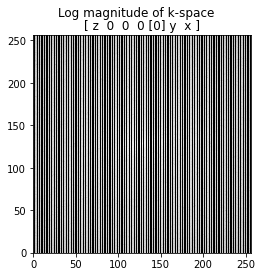

In [79]:
pl.ImagePlot(ksp_s, mode='l', z=0, title='Log magnitude of k-space')

In [77]:
mps.shape

(256, 256)

In [81]:
mps

array([[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -0.+0.j, -0.+0.j, ..., -0.+0.j, -0.+0.j, -0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [ 0.-0.j,  0.-0.j,  0.-0.j, ...,  0.-0.j,  0.-0.j,  0.-0.j],
       [ 0.-0.j,  0.-0.j,  0.-0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j, -0.+0.j, -0.+0.j, ..., -0.+0.j, -0.+0.j, -0.+0.j]])

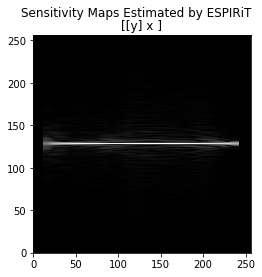

In [80]:
pl.ImagePlot(mps, title='Sensitivity Maps Estimated by ESPIRiT')


TypeError: Invalid shape (256,) for image data

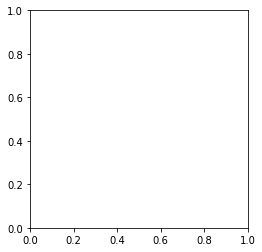

In [72]:
show_image(img_sense)
# pl.ImagePlot(img_sense, title='SENSE Reconstruction')
evaluate(img,img_sense)

In [349]:
coord.shape

(200, 256, 2)

In [356]:
coord_c = sp.gridding(ksp,(256,256))

TypeError: gridding() missing 1 required positional argument: 'shape'

In [350]:
# Compute preconditioner
ones = np.ones_like(mps[0])
ones /= len(mps[0])**0.5

p = mr.kspace_precond(ones, coord=coord, lamda=lamda)

pdhg_sc_img = mr.app.SenseRecon(
    ksp, mps, coord=coord, sigma=p, max_iter=max_iter, lamda=lamda,
    solver='PrimalDualHybridGradient', save_objective_values=True).run()

pl.ImagePlot(pdhg_sc_img)

/opt/anaconda3/lib/python3.8/site-packages/sigpy/mri/precond.py:54: RuntimeWarning: invalid value encountered in sqrt
  ones[idx] = weights**0.5


ValueError: could not broadcast input array from shape (200,256,2) into shape (256,)